In [1]:
import numpy as np

# PROBLEM 2

In [2]:
def load_data_and_labels():
    train = np.loadtxt("iris-train.txt")
    train_y = train[:,0]
    train_x = train[:, [1,2]]
    
    test = np.loadtxt("iris-test.txt")
    test_y = test[:,0]
    test_x = test[:, [1,2]]
    
    return train_x, train_y, test_x, test_y

iris_train_x, iris_train_y, iris_test_x, iris_test_y = load_data_and_labels()

In [3]:
iris_train_x.shape

(90, 2)

In [4]:
iris_train_y

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.])

## 2.1 

In [5]:
def calc_dp_matrix(data, weight_matrix):  
    return np.transpose(np.dot(np.transpose(weight_matrix), np.transpose(data)))

def softmax_vector(x):
    e_x = np.exp(x - np.max(x)) #subtracting the max makes it more stable #https://deepnotes.io/softmax-crossentropy 
    return e_x / e_x.sum()

def softmax_matrix(matrix, num_classes):
    N = matrix.shape[0]
    flat_output_matrix = np.array([])
    for data_point in matrix:
        flat_output_matrix = np.append(flat_output_matrix, softmax_vector(data_point))
        
    return flat_output_matrix.reshape(N, num_classes)
# def calc_dp_vector(data_point, weight_matrix):
#     return np.dot(np.transpose(weight_matrix), data_point)

# dp_vec = calc_dp_vector(train_x[0], weights)

# def forward_prop(data, current_weights):
#     # Step 1: Calculate dot product of data and weights
#     matrix_dot_product = calc_dp_matrix(data, current_weights)
#     # Step 2: Perform softmax to get probabilities for each class
#     return softmax_matrix(matrix_dot_product)


In [6]:
# preds = np.argmax(sample_output, axis=1) +

def indices(l, val):
    retval = []
    last = 0
    while val in l[last:]:
           i = l[last:].index(val)
           retval.append(last + i)
           last += i + 1   
    return retval

def class_accuracy(y_pred, y_true, class_num):
    y_pred = list(y_pred)
    y_true = list(y_true)
    index = indices(y_true, class_num)
#     print(index)
    y_pred, y_true = [y_pred[i] for i in index], [y_true[i] for i in index]
    tp = [1 for k in range(len(y_pred)) if y_true[k]==y_pred[k]]
    tp = np.sum(tp)
    return tp/float(len(y_pred))

def mean_per_class_accuracy(y_pred, y_true):
    return (class_accuracy(y_pred, y_true,1) + class_accuracy(y_pred, y_true,2) + class_accuracy(y_pred, y_true,3))/3



Normalize Data

In [7]:
def softmax_classifier(train_x, train_y, test_x, test_y, learning_rate, weight_decay, num_classes):
    NUM_EPOCHS = 10000
       
    mean_training_features = np.mean(train_x, axis=0)
    train_x_norm = train_x - mean_training_features
    test_x_norm = test_x - mean_training_features 
    
    NUM_FEATURES = train_x_norm.shape[1]
#     NUM_CLASSES = num_classes
    
    TRAIN_SAMPLE_SIZE = train_x_norm.shape[0]

    #MAKE ONE HOT LABELS
    one_hot_labels_train = np.zeros((TRAIN_SAMPLE_SIZE, num_classes))

    for i in range(TRAIN_SAMPLE_SIZE):  
        one_hot_labels_train[i, train_y[i] - 1] = 1

    one_hot_flat_train = one_hot_labels_train.reshape(1, one_hot_labels_train.shape[0] * one_hot_labels_train.shape[1])
    
    TEST_SAMPLE_SIZE = test_x_norm.shape[0]

    one_hot_labels_test = np.zeros((TEST_SAMPLE_SIZE, num_classes))

    for i in range(TEST_SAMPLE_SIZE):  
        one_hot_labels_test[i, test_y[i] - 1] = 1

    one_hot_flat_test = one_hot_labels_test.reshape(1, one_hot_labels_test.shape[0] * one_hot_labels_test.shape[1])
    
    np.random.seed(42)
    weights = np.random.rand(NUM_FEATURES, num_classes)
    
    train_loss_array = []
    test_loss_array = []

    train_accuracy_arr = []
    test_accuracy_arr = []
    
    for epoch in range(NUM_EPOCHS):  
        train_data = train_x_norm
        test_data = test_x_norm

        #FORWARD PROP:
        # Step 1: Calculate dot product of data and weights
        train_matrix_dot_product = calc_dp_matrix(train_data, weights)

        test_matrix_dot_product = calc_dp_matrix(test_data, weights)

        # Step 2: Perform softmax to get probabilities for each class
        train_activation_output = softmax_matrix(train_matrix_dot_product, num_classes)

        test_activation_output = softmax_matrix(test_matrix_dot_product, num_classes)

        #ACCURACY:
        train_preds = np.argmax(train_activation_output, axis=1) + 1
        train_mean_acc = mean_per_class_accuracy(train_preds, train_y)
        train_accuracy_arr.append(train_mean_acc)

        test_preds = np.argmax(test_activation_output, axis=1) + 1
        test_mean_acc = mean_per_class_accuracy(test_preds, test_y)
        test_accuracy_arr.append(test_mean_acc)

        #BACK PROP
        # Step 1: Compute Loss
        train_sm_flat = train_activation_output.reshape(train_activation_output.shape[0]*train_activation_output.shape[1],1)
        train_loggify_sm = np.log(train_sm_flat)   
        train_loss = (-1 * np.dot(one_hot_flat_train, train_loggify_sm)[0][0]) / train_data.shape[0]
        train_loss_array.append(train_loss)

        test_sm_flat = test_activation_output.reshape(test_activation_output.shape[0]*test_activation_output.shape[1],1)
        test_loggify_sm = np.log(test_sm_flat)   
        test_loss = (-1 * np.dot(one_hot_flat_test, test_loggify_sm)[0][0]) / test_data.shape[0]
        test_loss_array.append(test_loss)

        #Step 2: Find gradient 
        error_matrix = train_activation_output - one_hot_labels_train
        weight_diff = weight_decay*weights + np.transpose(np.dot(np.transpose(error_matrix), train_data))

        weights -= (learning_rate * weight_diff)
        
    return train_loss_array, test_loss_array, train_accuracy_arr, test_accuracy_arr

In [8]:
iris_train_loss, iris_test_loss, iris_train_accuracy, iris_test_accuracy = softmax_classifier(iris_train_x, iris_train_y, iris_test_x, iris_test_y, .07, .01, 3)

/Users/travisallen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/travisallen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


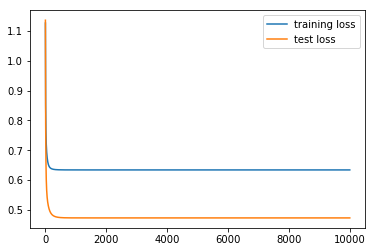

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(iris_train_loss)
plt.plot(iris_test_loss)

plt.legend(['training loss', 'test loss'], loc='upper right')

plt.show()

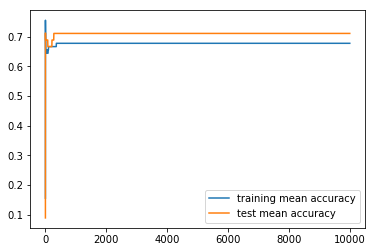

In [10]:
plt.plot(iris_train_accuracy)
plt.plot(iris_test_accuracy)
plt.legend(['training mean accuracy', 'test mean accuracy'], loc='lower right')
plt.show()

OLD

(32, 2)
(32,)
(32, 2)
(32,)


### MINI_BATCH IMPLEMENTATION

/Users/travisallen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/travisallen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


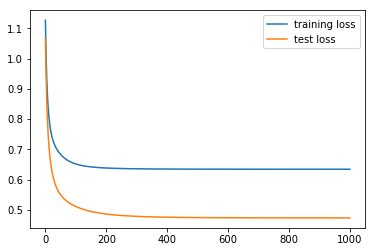

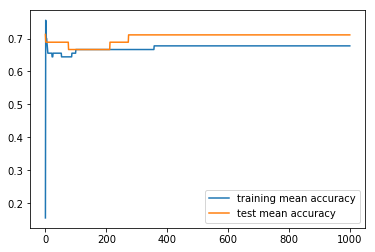

In [32]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        

def f_train(train_x_batch, train_y_batch, weights):
    one_hot_labels_train = np.zeros((BATCH_SIZE, NUM_CLASSES))

    for i in range(BATCH_SIZE):  # MAKE ONE-HOT-LABELS FOR BATCH
        one_hot_labels_train[i, train_y_batch[i] - 1] = 1

    one_hot_flat_train = one_hot_labels_train.reshape(1, one_hot_labels_train.shape[0] * one_hot_labels_train.shape[1])
    
    #FORWARD PROP:
    # Step 1: Calculate dot product of data and weights
    train_matrix_dot_product = calc_dp_matrix(train_x_batch, weights)
    
    # Step 2: Perform softmax to get probabilities for each class
    train_activation_output = softmax_matrix(train_matrix_dot_product, NUM_CLASSES)
    
    #ACCURACY:
    train_preds = np.argmax(train_activation_output, axis=1) + 1
    train_mean_acc = mean_per_class_accuracy(train_preds, train_y_batch)
    
    #BACKPROP
    # Step 1: Compute Loss
    train_sm_flat = train_activation_output.reshape(train_activation_output.shape[0]*train_activation_output.shape[1],1)
    train_loggify_sm = np.log(train_sm_flat)   
    train_loss = (-1 * np.dot(one_hot_flat_train, train_loggify_sm)[0][0]) / train_x_batch.shape[0]
    
    #Step 2: Find gradient 
    error_matrix = train_activation_output - one_hot_labels_train
    weight_diff = l2*weights + np.transpose(np.dot(np.transpose(error_matrix), train_x_batch))
    
    weights -= (lr * weight_diff)
    
    return train_mean_acc, train_loss, weights
    
#SET PARAMETERS
lr = .07
l2 = .01
NUM_EPOCHS = 1000
BATCH_SIZE = 90

#NORMALIZE THE DATA
mean_training_features = np.mean(iris_train_x, axis=0)

train_x_norm = iris_train_x - mean_training_features
test_x_norm = iris_test_x - mean_training_features 

NUM_CLASSES = 3
NUM_FEATURES = train_x_norm.shape[1]

TRAIN_SAMPLE_SIZE = train_x_norm.shape[0]
TEST_SAMPLE_SIZE = test_x_norm.shape[0]
    
#GENERATE ONE-HOT-LABELS FOR TEST DATA   
one_hot_labels_test = np.zeros((TEST_SAMPLE_SIZE, NUM_CLASSES))

for i in range(TEST_SAMPLE_SIZE):  
    one_hot_labels_test[i, iris_test_y[i] - 1] = 1

one_hot_flat_test = one_hot_labels_test.reshape(1, one_hot_labels_test.shape[0] * one_hot_labels_test.shape[1])

# INITIALIZE WEIGHTS
np.random.seed(42)
weights = np.random.rand(NUM_FEATURES, NUM_CLASSES) # initizialize m * K weight matrix

train_loss_array = []
test_loss_array = []

train_accuracy_arr = []
test_accuracy_arr = []

    
for epoch in range(NUM_EPOCHS):
    train_data = train_x_norm
    test_data = test_x_norm
    
    batch_accuracies = []
    batch_losses = []
    
    for batch in iterate_minibatches(train_data, iris_train_y, BATCH_SIZE, shuffle=True):
        x_batch, y_batch = batch      
        acc_train, l_train, weights = f_train(x_batch, y_batch, weights)
#         print(l_train)
        batch_losses.append(l_train)
        batch_accuracies.append(acc_train)
    
    avg_batch_loss = np.mean(batch_losses)
    avg_batch_acc = np.mean(batch_accuracies)
    
    train_loss_array.append(avg_batch_loss)
    train_accuracy_arr.append(avg_batch_acc)

#    TEST -- FIND test accuracy and test loss
#     FORWARD PROP:
#     Step 1: Calculate dot product of data and weights    
    test_matrix_dot_product = calc_dp_matrix(test_data, weights)
    
    # Step 2: Perform softmax to get probabilities for each class    
    test_activation_output = softmax_matrix(test_matrix_dot_product,NUM_CLASSES)
    
    test_preds = np.argmax(test_activation_output, axis=1) + 1
    test_mean_acc = mean_per_class_accuracy(test_preds, iris_test_y)
    test_accuracy_arr.append(test_mean_acc)
    
    #BACK PROP
    # Step 1: Compute Loss
    
    test_sm_flat = test_activation_output.reshape(test_activation_output.shape[0]*test_activation_output.shape[1],1)
    test_loggify_sm = np.log(test_sm_flat)   
    test_loss = (-1 * np.dot(one_hot_flat_test, test_loggify_sm)[0][0]) / test_data.shape[0]
    test_loss_array.append(test_loss)
    


import matplotlib.pyplot as plt
import numpy as np

plt.plot(train_loss_array)
plt.plot(test_loss_array)

plt.legend(['training loss', 'test loss'], loc='upper right')

plt.show()

plt.plot(train_accuracy_arr)
plt.plot(test_accuracy_arr)
plt.legend(['training mean accuracy', 'test mean accuracy'], loc='lower right')
plt.show()

## 2.2: Decision Boundaries

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

In [19]:
np.random.seed(0)

X, y = train_x, train_y
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
# clf = sklearn.linear_model.LogisticRegressionCV()
# clf.fit(X, y)

def plot_decision_boundary(pred_func):

    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
plot_decision_boundary(lambda x: my_predict())

# # clf.predict(X)

def my_predict(X):
    return train_preds

# my_predict()

NameError: name 'train_x' is not defined

## Problem 3:  

In [20]:
def loadCIFAR10():
    def unpickle(file):
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict
    
    train_batch_1 = unpickle("./CIFAR_DATA/data_batch_1")
    train_batch_2 = unpickle("./CIFAR_DATA/data_batch_2")
    train_batch_3 = unpickle("./CIFAR_DATA/data_batch_3")
    train_batch_4 = unpickle("./CIFAR_DATA/data_batch_4")
    train_batch_5 = unpickle("./CIFAR_DATA/data_batch_5")
        
    trainFeat = np.concatenate((train_batch_1['data'], train_batch_2['data'], train_batch_3['data'], train_batch_4['data'], train_batch_5['data']))
    trainLabels = np.concatenate((train_batch_1['labels'], train_batch_2['labels'], train_batch_3['labels'], train_batch_4['labels'], train_batch_5['labels']))
    
    test_batch = unpickle("./CIFAR_DATA/test_batch")
    
    testFeat = test_batch['data']
    testLabels = test_batch['labels']
    
    return trainLabels, trainFeat, testLabels, testFeat
    
    
cifar_train_y, cifar_train_x, cifar_test_y, cifar_test_x = loadCIFAR10()

In [ ]:
def print_first_three():
    
#     def plot_image(img):
#         blah = trainFeat[0].reshape(32,32,3)
#         plt.imshow(blah)
    
    counter = 0
    for label in range(0,10):
        print label
        for idx, train_label in enumerate(cifar_train_y):
            if counter == 3:
                counter = 0
                break
            if(train_label == label):
                plt.imshow(cifar_train_x[idx].reshape(32,32,3))
                counter += 1



print_first_three()

# Problem 4

In [ ]:
cifar_train_loss, cifar_test_loss, cifar_train_accuracy, cifar_test_accuracy = softmax_classifier(cifar_train_x, cifar_train_y, cifar_test_x, cifar_test_y, .07, .01, 10)

SAMPLE EXPERIMENT

In [ ]:
w = np.array([1,3,2,2,4,5])

In [ ]:
np.exp([17])

In [ ]:
np.exp(17)/(np.exp(17)+np.exp(39)+np.exp(40))

In [ ]:
np.exp(39)/(np.exp(17)+np.exp(39)+np.exp(40))

In [ ]:
np.exp(40)/(np.exp(17)+np.exp(39)+np.exp(40))

In [ ]:
np.exp([17,39,40])/(np.exp(17) + np.exp(39)+np.exp(40))

LOSS CALCULATION:

In [ ]:
softmax_output_dummy = np.array([[.5, .4, .1], [.2, .1, .7]])
one_hot_label_dummy = np.array([[0,1,0], [0,0,1]])


In [ ]:
oh_rs = one_hot_label_dummy.reshape(1, one_hot_label_dummy.shape[0] * one_hot_label_dummy.shape[1])
sm_rs = softmax_output_dummy.reshape(softmax_output_dummy.shape[0]*softmax_output_dummy.shape[1],1)
loggify_sm = np.log(sm_rs)
loss = -1 * np.dot(oh_rs, loggify_sm)[0][0]

In [ ]:
sm_rs = softmax_output_dummy.reshape(softmax_output_dummy.shape[0]*softmax_output_dummy.shape[1],1)
sm_rs

In [ ]:
loggify_sm = np.log(sm_rs)
loggify_sm

In [ ]:
-1 * np.dot(oh_rs, loggify_sm)[0][0]